# Cluster Analysis

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
import elec_consumption.performance as performance
import elec_consumption.cluster as cluster 
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
import pprint
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
from tslearn.clustering import KShape, TimeSeriesKMeans
from tslearn.utils import (
    check_equal_size, to_time_series_dataset, to_sklearn_dataset
)

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6 * 1.61803398875, 6]
_seed = 123  # for clustering analysis
mts = {}  # different multivariate time series
data = {}  # different dataframe
graphs = {}  # graph used in clustering
labels_dict = {}  # labels from clustering
results = {}  # clustering results

## 1. Introduction

There are at least two challenges in this task:

1. Too many missing days distribute differently among units.
2. All series are non-stationary because of non-business-days.

### Why not k-Means

There are dedicated implementation of k-means clustering for time series, like [`tslearn.clustering.TimeSeriesKMeans`](https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.TimeSeriesKMeans.html). However, missing entries must be filled with meaningfull values first, or the algorithm does not work. As shown before, there are only 186 time index when entries are complete. Clearly, neither to fill with 0 nor to interpolate is a good choice in terms of time series.

Monte Carlo simulations can be used, but the resulted effect is not known. The argument is that such common clustering algorithms rely on calculation of cluster centres, which involve multiple units at the same time. Nevertheless, the joint set of missing days from those units might be large compared to that from pair-wise units, so simulated entries exist in more time index, distorting cluster centres.

Moreover, most methods to validate cluster results are based on original data, so they cannot be used, either. Probably the only option left is to validate based on pair-wise similarity measures, like Euclidean distance and Pearson correlation.

For these reasons, it is a good idea to use agglomerative hierarchical clustering with single linkage, which is discussed in the following section.

In [ ]:
#hide
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

In [ ]:
#hide
mts['raw'] = to_sklearn_dataset(to_time_series_dataset(df.T))
mts['fill0'] = to_time_series_dataset(df.fillna(0).T)
n_ts, max_sz, d = mts['fill0'].shape

In [ ]:
#hide
assert (n_ts == 500 and max_sz == 5856 and d == 1)
assert check_equal_size(mts['fill0'])

## 2. Agglomerative Hierarchical (Single Linkage)

Agglomerative hierarchical clustering (AHC) using single linkage relies on some distance matrix resulted from original data only. Entries in such distance matrix measure the similarity of some unit pair according to a pre-defined criterion. For similarity between time series, Pearson correlation, instead of Euclidean distance, is usually used.



To compute pair-wise correlation, data points with NaNs are removed. Resulted distance matrix has two NaN entries, (463, 485) and (485, 463). They are set as 0 for now.

In [ ]:
#hide
data['corr'] = df.corr()
assert cluster.inspect_nan_corr(data['corr']) == [(463, 485), (485, 463)]

2020-12-18 09:39:22.958 | WARNING  | elec_consumption.cluster:inspect_nan_corr:211 - There are NaN entries: [(463, 485), (485, 463)].


In [ ]:
#hide
data['corr'].loc[485, 463] = 0
data['corr'].loc[463, 485] = 0

When number of clusters is set to 4, for example, differences in sizes -- 497, 1, 1, 1 respectively -- are significant. The reason is that units in last three clusters do not have strong correlation with any other unit. That is, they are outliers. Though their distribution among clusters does not have a huge impact, they prevent the algorithm to process units in the first big cluster.


In [ ]:
#hide
n_clusters = 4
mod = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='single')
res = mod.fit_predict(data['corr'])
print([list(res).count(i) for i in range(n_clusters)])

[497, 1, 1, 1]


A method based on weighted graphs is proposed in the following section to handle this issue.

## 3. Max Spanning Tree on Distance Matrix

AHC using single linkage is an optimisation problem in essence. To run max spanning tree on distance matrix yields better result, actually. Another advantage of this approach is that the complete graph (with lightgrey-coloured edges in the following figure), which represesnts the distance matrix, provides a more intuitive way to choose clusters.

### Demo with Units 70 ~ 99

Units 70 ~ 99 are considered in the following example, resulting a clearer figure.

In [ ]:
#hide
tree, graph = cluster.mst_corr(df.iloc[:, 70:100])
pos = nx.spring_layout(tree, seed=100)

The min spanning tree of the complete graph is highlighted by black edges. The following table highlights two units with high degrees: 77 and 79. They can be seen as representative units for two clusters. Besides, based on the graph figure, it seems to be a good idea to have another cluster, represented by unit 99.

In [ ]:
#hide_input
cluster.gather_nodes_info(tree).head(10).T

,77,79,98,99,93,94,84,96,80,92
degree,11,10,3,3,2,2,2,2,2,1


Weakest links between such units (two blue edges) are found. If they are removed, the tree becomes a forest with three components, which correspond to three clusters.

In [ ]:
#hide
cluster.remove_weak_edges(tree, [77, 79, 99])

2020-12-18 09:39:23.076 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 77-79 has been removed.
2020-12-18 09:39:23.078 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 77-99 has been removed.


{77: [70, 71, 76, 77, 82, 86, 88, 92, 94, 95, 97],
 79: [72, 73, 75, 78, 79, 83, 84, 85, 87, 89, 90, 91, 98],
 99: [74, 80, 81, 93, 96, 99]}

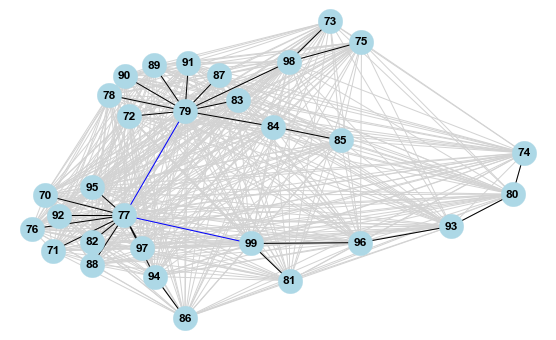

In [ ]:
#hide_input
nx.draw_networkx_edges(graph, pos, edge_color='lightgrey')
nx.draw_networkx_edges(
    graph, pos, edgelist=[(77, 79), (77, 99)], edge_color='b'
)
cluster.draw_graph(tree, pos)

The resulted cluster with household 77 being representative unit, for example, has another 10 members: 71, 76, 77, 82, 86, 88, 92, 94, 95, and 97.

In [ ]:
#hide
households_centre_77 = list(nx.node_connected_component(tree, 77))
households_centre_77.sort()
print(households_centre_77)

[70, 71, 76, 77, 82, 86, 88, 92, 94, 95, 97]


The distance matrix can be sorted according to clusters. Here is a heatmap for the previous example. Correlations between members within clusters are shown by three diagonal block matrices, whose entries seem to have higher values. In constrast, off-diagonal block matrices represent inter-cluster correlations, which tend to be low and even negative. So the clustering result is satisfying.

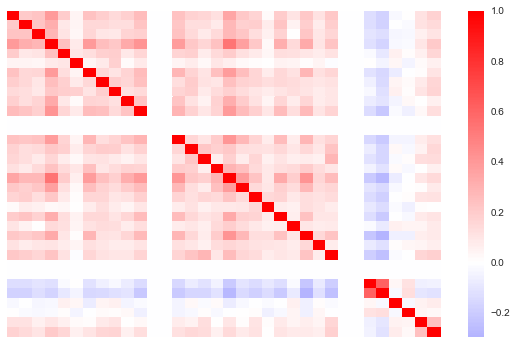

In [ ]:
#hide_input
cluster.plot_corr_mat(tree, [77, 79, 99], df, 2)

To determine the number of clusters is not a trivial task. With distance matrix and max spanning tree visualised, it is relatively easier to try different numbers and validate results using heatmaps.

## 4. Effect of Different Resolutions

All the units are to be clustered in this section. Hourly and daily down-sampled profiles are used respectively in first two parts, and results are compared.

### Using Hourly Profiles

In [ ]:
#hide
data['hourly'] = df.resample('1H', closed='left').mean()
graphs['hourly'], _ = cluster.mst_corr(data['hourly'])

2020-12-18 09:39:26.802 | WARNING  | elec_consumption.cluster:inspect_nan_corr:211 - There are NaN entries: [(463, 485), (485, 463)].


Here are nodes with high degrees, which are seen as potential representative units:

In [ ]:
#hide_input
cluster.gather_nodes_info(graphs['hourly']).head(10).T

,3,79,77,54,197,68,48,222,223,457
degree,100,46,35,24,16,12,12,10,9,9


Will choose 3, 79, 77, 54, and 197 as representative households. It results in 5 clusters.

In [ ]:
#hide
representatives = [3, 79, 77, 54, 197]
results['hourly'] = cluster.remove_weak_edges(graphs['hourly'], representatives)
labels_dict['hourly'] = cluster.get_labels(results['hourly'])

2020-12-18 09:39:27.877 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 3-79 has been removed.
2020-12-18 09:39:27.887 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 3-77 has been removed.
2020-12-18 09:39:27.890 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 3-197 has been removed.
2020-12-18 09:39:27.892 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 79-54 has been removed.
2020-12-18 09:39:27.938 | INFO     | elec_consumption.cluster:get_labels:229 - There are 500 units.


Here is a heatmap for sorted correlation matrix after clustering. Results are satisfying.

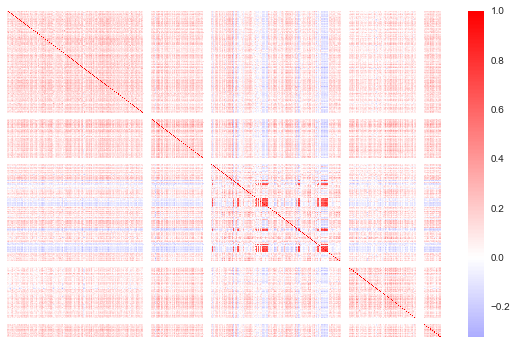

In [ ]:
#hide_input
cluster.plot_corr_mat(graphs['hourly'], representatives, df, 10)

### Using Daily Profiles

In [ ]:
#hide
data['daily'] = df.resample('1D', closed='left').mean()
graphs['daily'], _ = cluster.mst_corr(data['daily'])
pos = nx.spring_layout(graphs['daily'], seed=123)

2020-12-18 09:39:30.662 | WARNING  | elec_consumption.cluster:inspect_nan_corr:211 - There are NaN entries: [(463, 485), (485, 463)].


Here are units with high degrees, and household 80, 74, 155, 249 are chosen as potential representative units. So number of clusters is 4.

In [ ]:
#hide_input
cluster.gather_nodes_info(graphs['daily']).head(10).T

,80,74,155,249,388,68,456,465,478,222
degree,31,17,10,10,9,9,8,8,7,7


In [ ]:
#hide
representatives = [80, 74, 155, 249]
results['daily'] = cluster.remove_weak_edges(graphs['daily'], representatives)
labels_dict['daily'] = cluster.get_labels(results['daily'])

2020-12-18 09:39:33.884 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 458-457 has been removed.
2020-12-18 09:39:33.886 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 80-155 has been removed.
2020-12-18 09:39:33.889 | DEBUG    | elec_consumption.cluster:remove_weak_edges:148 - Edge 5-154 has been removed.
2020-12-18 09:39:33.892 | INFO     | elec_consumption.cluster:get_labels:229 - There are 500 units.


Here is a heatmap for sorted correlation matrix after clustering.

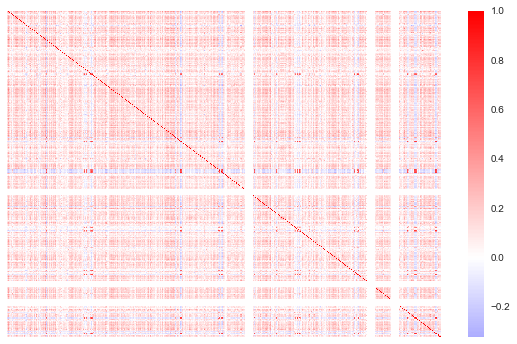

In [ ]:
#hide_input
cluster.plot_corr_mat(graphs['daily'], representatives, df, 10)

### Compare Results

In [ ]:
#hide
comparison = {}  # metrics used to compare clustering results

Units are usually labelled by integers in clustering result, and integer values are irrelevant. Some metrics can be used to quantify difference between two clustering results. Three symmetric metrics are used here, because the true label is unknown.

Adjusted Rand index is 1 when two clustering results are exactly the same, and being -1 corresponds to the biggest difference possible. There are another two indices. Normalized mutual information (NMI) is often used in the literature, while adjusted mutual information (AMI) was proposed more recently and is normalized against chance. (1 is best; negative is bad)

In [ ]:
#hide
comparison['rand'] = (
    'adjusted Rand index',
    metrics.adjusted_rand_score(
        labels_dict['hourly'], labels_dict['daily']
    ),
    "close to -1",
    "close to 1",
)
comparison['AMI'] = (
    'adjusted mutual information',
    metrics.adjusted_mutual_info_score(
        labels_dict['hourly'], labels_dict['daily']
    ),
    "being negative",
    "close to 1",
)
#hide
comparison['NMI'] = (
    'normalized mutual information',
    metrics.normalized_mutual_info_score(
        labels_dict['hourly'], labels_dict['daily']
    ),
    "being negative",
    "close to 1",
)

In [ ]:
#hide_input
res = pd.DataFrame.from_dict(comparison, orient='index')
res.columns = [
    'index', 'value', 'when results are different',
    'when results are similar'
]
res

,index,value,when results are different,when results are similar
rand,adjusted Rand index,-0.015766,close to -1,close to 1
AMI,adjusted mutual information,0.016228,being negative,close to 1
NMI,normalized mutual information,0.026368,being negative,close to 1


So, two clustering results are quite different. There are multiple reasons behind:

- Lots of variation is lost when profiles are down-sampled in daily resolution.
- Outliers (spikes) may distort two results in different manners.
- The fact that missing entries come in batchs has significant impact on clustering with hourly profiles.

How to handle and analyse such issues is discussed in the next section.

## 5. Future Work

- Multiple results with different number of clusters should be investigated.
- __Structured clustering__ is to cluster based on parameters in statistical models. It is especially handy to cluster time series.
- Pearson coefficients are based on original profiles for now. Scaling (amplitude) and translation (offset) variances most likely dominate clustering results. Preprocessing can be applied to reduce such effect.
- Sum of inter-cluster correlations should be minimised at the same time, the problem can be formulated as an MILP, which, however, can be NP-hard.
- Outlier can be detected and removed, reducing their impact on squared terms in some commands.

## 6. Results

Clusters based on hourly profiles:

In [ ]:
#hide_input
for key in results['hourly'].keys():
    print(f"{key}: {results['hourly'][key]} \n")

3: [1, 3, 8, 10, 16, 25, 26, 29, 32, 36, 40, 41, 42, 45, 49, 50, 55, 59, 61, 65, 67, 71, 72, 73, 76, 78, 82, 84, 86, 87, 92, 94, 95, 96, 99, 106, 110, 111, 113, 129, 134, 137, 138, 139, 141, 143, 146, 147, 155, 156, 157, 159, 161, 164, 169, 177, 184, 189, 193, 198, 199, 203, 205, 206, 209, 211, 213, 217, 220, 223, 224, 225, 226, 228, 230, 232, 233, 234, 235, 238, 241, 243, 246, 255, 256, 257, 259, 262, 264, 266, 268, 270, 278, 279, 280, 283, 285, 290, 295, 297, 298, 299, 301, 305, 306, 307, 308, 312, 313, 315, 316, 318, 322, 323, 325, 327, 330, 331, 332, 334, 335, 336, 337, 340, 341, 342, 348, 349, 351, 361, 363, 364, 369, 373, 375, 379, 380, 382, 399, 400, 406, 408, 410, 411, 414, 417, 418, 421, 427, 428, 429, 431, 435, 437, 446, 448, 452, 454, 459, 460, 467, 479, 480, 481, 483, 488, 489, 490, 492, 499] 

79: [0, 9, 12, 21, 27, 38, 46, 53, 63, 79, 83, 85, 90, 91, 112, 131, 132, 133, 136, 140, 144, 148, 152, 162, 163, 165, 178, 179, 204, 221, 227, 236, 239, 244, 245, 252, 265, 272, 274

Clusters based on daily profiles:

In [ ]:
#hide_input
for key in results['daily'].keys():
    print(f"{key}: {results['daily'][key]} \n")

80: [1, 2, 3, 8, 10, 11, 12, 13, 17, 18, 19, 21, 22, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 37, 38, 40, 41, 42, 45, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 62, 63, 64, 67, 69, 70, 71, 76, 77, 80, 83, 84, 86, 88, 89, 90, 91, 94, 97, 98, 100, 104, 106, 107, 108, 109, 110, 112, 113, 114, 115, 116, 117, 118, 120, 128, 129, 132, 134, 136, 141, 146, 147, 148, 149, 151, 152, 153, 158, 159, 160, 161, 163, 165, 166, 168, 172, 173, 174, 175, 177, 178, 179, 181, 185, 188, 190, 193, 195, 197, 198, 199, 200, 201, 202, 203, 205, 206, 209, 212, 217, 218, 221, 223, 225, 227, 228, 229, 230, 232, 234, 238, 239, 240, 242, 243, 246, 247, 248, 252, 253, 254, 256, 257, 259, 261, 264, 268, 269, 271, 272, 274, 275, 276, 277, 279, 281, 282, 283, 284, 286, 288, 292, 293, 294, 295, 297, 298, 299, 300, 301, 302, 304, 306, 307, 308, 311, 312, 313, 314, 315, 316, 317, 319, 324, 325, 328, 329, 330, 332, 333, 334, 337, 338, 340, 342, 344, 345, 346, 350, 353, 355, 356, 357, 358, 359, 360, 362, 363, 365, 366, 367, 369

## Appendix. Four Cluster using k-Means 

To show why k-Means clustering is not an ideal choice, it is used here. For example, assume there are 4 clusters.

In [ ]:
#hide
n_clusters = 4
km = TimeSeriesKMeans(
    n_clusters=n_clusters, verbose=False, random_state=_seed)
clustered = km.fit_predict(mts['fill0'])

description = df.describe().T
description['cluster_id'] = clustered

### Performance Evaluation using Silhouett Analysis

In [ ]:
#hide
mts['fill0sk'] = to_sklearn_dataset(mts['fill0'])

Results are not satifying.

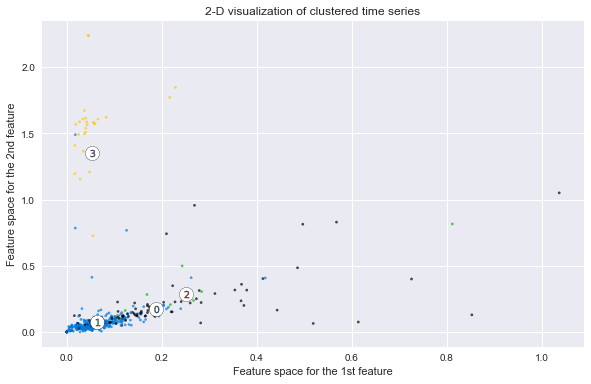

In [ ]:
#hide_input
performance.plot_silhouette_2d(
    n_clusters, clustered, mts['fill0sk'], centers=km.cluster_centers_
)

For n_clusters = 4,  the average silhouette_score is : 0.27821213695582137.


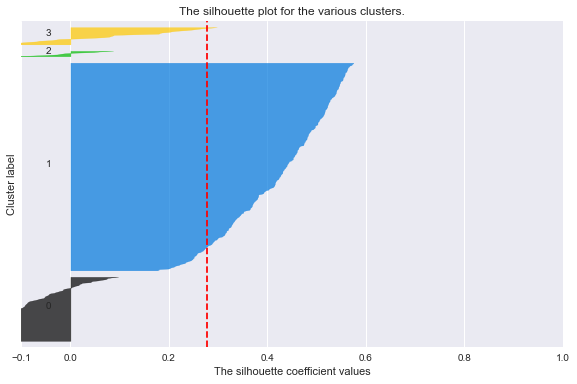

In [ ]:
#hide_input
performance.plot_silhouette(
    n_clusters, clustered, mts['fill0sk']
)